In [33]:
from __future__ import print_function
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.9170, 0.7354, 0.0345],
        [0.4523, 0.0072, 0.4204],
        [0.1006, 0.4761, 0.1209],
        [0.1823, 0.1598, 0.3409],
        [0.2591, 0.9284, 0.3497]])


In [32]:
#!pip install fastai==0.7.0 --no-deps
#!pip install torch==0.4.1 torchvision==0.2.1
#!conda install -c conda-forge anaconda bcolz
#!conda install pytorch-cpu torchvision-cpu -c pytorch
!pip3 install Cython

In [20]:
#imports
import torch,cv2
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()
#fastai related imports
import fastai
from fastai.learner import *
from fastai.column_data import *
import seaborn as sns
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings("ignore")

#torch.cuda.is_available()

Loading BokehJS ...

In [21]:
print(torch.__version__)

0.4.1


In [22]:
path='/Users/ilonakulikovskikh/code/interactions/' #path to the dataset
ratings = pd.read_csv(f'{path}ratings.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [23]:
movies = pd.read_csv(f'{path}movies.csv')
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [24]:
ratings = ratings.drop(['timestamp'],axis = 1) #dropping the timestamp variable..not important for this study
len(ratings)

100836

In [25]:
val_idxs = get_cv_idxs(len(ratings)) #get validation indices (default 20% of data)
wd=2e-4 #weight decay
n_factors = 50 #how big embedding matrix we want
len(val_idxs)

20167

In [26]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating') #creating a custom dataloader
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam) #create a learner (model) and specify the batch size and optimizer

In [31]:
learn.fit(1e-2, n_cycle = 1) #training with learning rate as 1e-2

RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -Wl,--no-as-needed in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using ldd on your binary to see if there is a dependency on *_cuda.so library.

In [80]:
preds = learn.get_preds() #this will predict ratings for validation dataset

In [81]:
preds[1]

tensor([3.5000, 4.0000, 4.5000,  ..., 2.0000, 4.5000, 1.0000])

In [82]:
learn.data.valid_ds[2]

(CollabLine userId 15; movieId 1653; , FloatItem 4.5)

/Users/ilonakulikovskikh/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


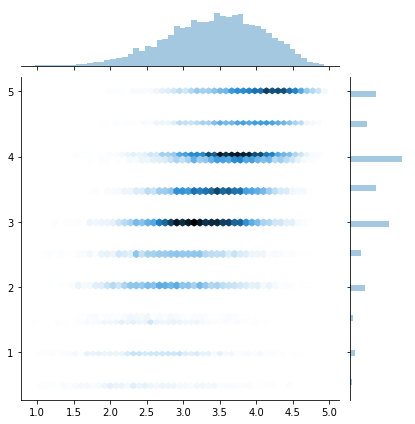

In [83]:
sns.jointplot(preds[0], preds[1], kind='hex', stat_func=None);

In [84]:
math.sqrt(metrics.mean_squared_error(preds[0], preds[1])) #RMSE for validation dat

0.8452785210117439

## Interpreting embeddings and biases

In [85]:
from sklearn.manifold import TSNE

In [113]:
movie_names = movies.set_index('movieId')['title'].to_dict() #creating dictionary of movieid: movie title
g=ratings.groupby('movieId')['rating'].count() #counting the number of ratings for each movie
topMovies=g.sort_values(ascending=False).index.values[:3000] #top 3000 movies based on number of ratings
topMovieIdx = np.array([data.item2idx[o] for o in topMovies]) #id for the top movies to link it to the embedding and bias matrix created by the model

AttributeError: item2idx

In [112]:
g

movieId
1         215
2         110
3          52
4           7
5          49
6         102
7          54
8           8
9          16
10        132
11         70
12         19
13          8
14         18
15         13
16         82
17         67
18         20
19         88
20         15
21         89
22         36
23         16
24         28
25         76
26         13
27          9
28         11
29         38
30          3
         ... 
188189      1
188301      3
188675      1
188751      1
188797      1
188833      1
189043      1
189111      1
189333      2
189381      1
189547      1
189713      1
190183      1
190207      1
190209      1
190213      1
190215      1
190219      1
190221      1
191005      1
193565      1
193567      1
193571      1
193573      1
193579      1
193581      1
193583      1
193585      1
193587      1
193609      1
Name: rating, Length: 9724, dtype: int64

In [105]:
topMovies

array([  356,   318,   296,   593, ...,  3392, 31427,   347, 27721])

In [96]:
topMovieIdx

array([[  4., 919.,   5.],
       [  4., 919.,   5.],
       [  4., 919.,   5.],
       [  4., 919.,   5.],
       ...,
       [  4., 919.,   5.],
       [  4., 919.,   5.],
       [  4., 919.,   5.],
       [  4., 919.,   5.]])